In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

### Systemgleichungen


In [2]:
a=1.3
b=0.9
c=0.5
d=1.8

def rb(x, t):
    return [
        a*x[0] - b*x[0]*x[1],
        c*x[0]*x[1] - d*x[1]
    ]

In [24]:
# Generate measurement data / training data
dt = 0.001

x0=1 #0.4425
y0=1 #4.6281

t_train = np.arange(0, 10, dt)
x0_train = [x0, y0]
x_train = odeint(rb, x0_train, t_train)
print(x_train)

[[1.         1.        ]
 [1.00040066 0.99870094]
 [1.00080266 0.99740378]
 ...
 [1.74106372 0.41022784]
 [1.74268535 0.40984689]
 [1.74430908 0.40946663]]


In [25]:
differentiation_method = ps.FiniteDifference(order=2)
# feature_library = ps.FourierLibrary()
feature_library = ps.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=0.2)
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model.fit(x_train, t=dt)
model.print()

x' = 1.300 x + -0.900 x y
y' = -1.800 y + 0.500 x y


In [13]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([1,2])
x_test = odeint(rb, x0_test, t_test)  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


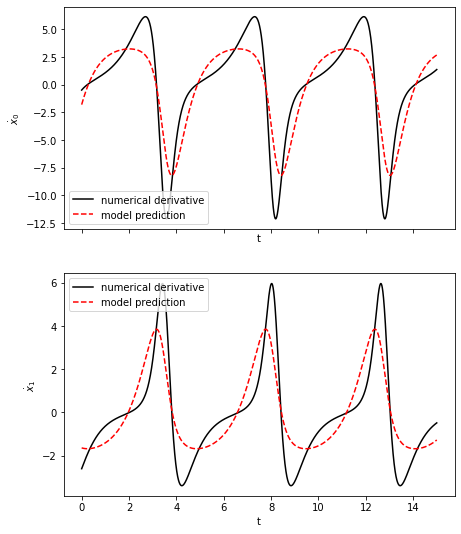

In [54]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

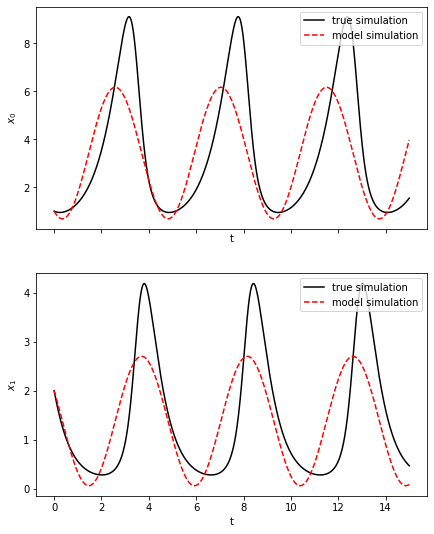

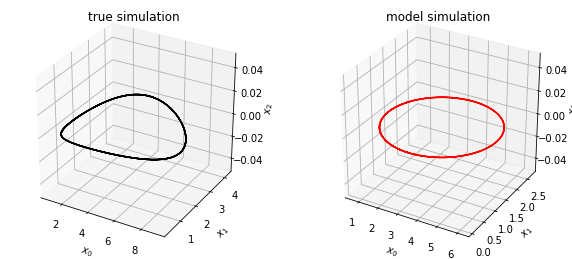

In [55]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()